In [1]:
!pip install ultralytics opencv-python pytesseract numpy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cv2
import os
import numpy as np
from ultralytics import YOLO

In [4]:
IMAGE_DIR = "/content/drive/MyDrive/YOLO_Models/images"
CROP_DIR = "/content/drive/MyDrive/YOLO_Models/crops"
VIS_DIR = "/content/drive/MyDrive/YOLO_Models/visualized"
CONF_THRESHOLD = 0.4

os.makedirs(CROP_DIR, exist_ok=True)
os.makedirs(VIS_DIR, exist_ok=True)

In [5]:
model = YOLO("/content/drive/MyDrive/YOLO_Models/best_license-11n.pt")

In [6]:
def preprocess_plate(plate_img):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

    gray = cv2.resize(
        gray, None,
        fx=2, fy=2,
        interpolation=cv2.INTER_CUBIC
    )

    thresh = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11,
        2
    )

    if thresh.mean() < 127:
        thresh = cv2.bitwise_not(thresh)

    return thresh

In [7]:
for img_name in os.listdir(IMAGE_DIR):

    if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(IMAGE_DIR, img_name)
    image = cv2.imread(img_path)

    if image is None:
        continue

    # Run YOLO detection
    results = model(image)

    # -----------------------------
    # PROCESS YOLO DETECTIONS (inside image loop!)
    # -----------------------------
    for i, box in enumerate(results[0].boxes):

        # Get confidence of detection
        conf = float(box.conf[0])
        if conf < CONF_THRESHOLD:
            continue  # skip low-confidence boxes

        # Get bounding box coordinates
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Crop the detected plate
        plate_crop = image[y1:y2, x1:x2]
        if plate_crop.size == 0:
            continue  # skip empty crops

        # Preprocess plate
        processed_plate = preprocess_plate(plate_crop)

        # Save cropped plate
        crop_name = f"{os.path.splitext(img_name)[0]}_plate_{i}.png"
        cv2.imwrite(os.path.join(CROP_DIR, crop_name), processed_plate)

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"plate {conf:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Save visualized image
    cv2.imwrite(os.path.join(VIS_DIR, img_name), image)


0: 448x640 1 number_plate, 1016.3ms
Speed: 21.6ms preprocess, 1016.3ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x384 1 number_plate, 543.1ms
Speed: 9.9ms preprocess, 543.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 2 number_plates, 396.9ms
Speed: 7.8ms preprocess, 396.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 number_plates, 249.5ms
Speed: 7.7ms preprocess, 249.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


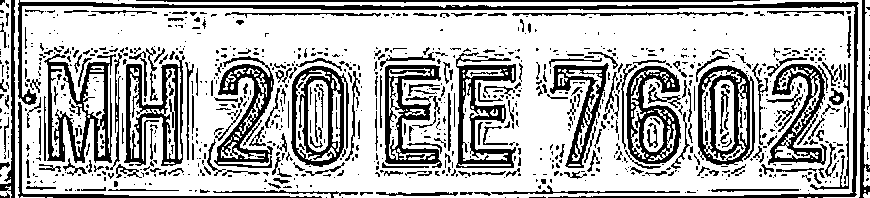

In [8]:
from IPython.display import Image, display
import os

sample = os.listdir(CROP_DIR)[0]
display(Image(filename=os.path.join(CROP_DIR, sample)))

In [30]:
!apt-get install -y tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [31]:
import pytesseract
import cv2
import os
import random
import re

custom_config = (
    "--oem 3 "
    "--psm 7 "
    "-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
)

all_crops = os.listdir(CROP_DIR)
sample_crops = random.sample(all_crops, min(10, len(all_crops)))

for crop_file in sample_crops:
    path = os.path.join(CROP_DIR, crop_file)
    img = cv2.imread(path)

    if img is None:
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    _, thresh = cv2.threshold(gray, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    text = pytesseract.image_to_string(thresh, config=custom_config)
    text = re.sub(r'[^A-Z0-9]', '', text.upper())

    print(f"{crop_file}: {text}")

images_plate_0.png: 
1_qre-gAVNTuazaUPvNw2w-Q_plate_0.png: WH20EE7602
gray1_plate_0.png: 29433185
skoda-india-front-license-plate_plate_0.png: 20002363
gray1_plate_1.png: SWP
skoda-india-front-license-plate_plate_1.png: 


In [28]:
!pip install -q rapidocr-onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.3 MB/s eta 0:00:00


In [29]:
from rapidocr_onnxruntime import RapidOCR
import cv2
import os
import random
import re

engine = RapidOCR()

all_crops = os.listdir(CROP_DIR)
sample_crops = random.sample(all_crops, min(10, len(all_crops)))

for crop_file in sample_crops:
    path = os.path.join(CROP_DIR, crop_file)
    img = cv2.imread(path)

    if img is None:
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    result, _ = engine(gray)

    if result:
        text = ''.join([line[1] for line in result])
    else:
        text = ""

    text = re.sub(r'[^A-Z0-9]', '', text.upper())
    print(f"{crop_file}: {text}")

1_qre-gAVNTuazaUPvNw2w-Q_plate_0.png: 
gray1_plate_0.png: 29A33185
gray1_plate_1.png: 
skoda-india-front-license-plate_plate_1.png: 
skoda-india-front-license-plate_plate_0.png: MH20DV2363
images_plate_0.png: KU2633344
